# load

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd

import numpy as np

from pathlib import Path

from tqdm.notebook import tqdm

import lifelines

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedGroupKFold

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt

import copy as cp

import pickle as pkl

# Survival data

In [31]:
# load survival
def load_survival(
    cancer,
    path_to_clinical=Path('/Data_hackathon/train.csv')
):
    """Load a dataframe containing OS data.
    
    Parameters
    ----------
    cancer: str
        One of the TCGA project ids (e.g. 'TCGA-LIHC')
    path_to_clinical: str or PosixPath
        Path to the csv file containing TCGA clinical data

    Returns
    -------
    df: DataFrame
        Dataframe with columns 'submitter_id', 'OS_time' and 'OS_event'
    """
    df = pd.read_csv(path_to_clinical)
    if cancer != 'pancancer':
        df = df.loc[df['cancer'] == cancer]
    return df

In [21]:
df

,patient,time,event,cancer,cancer_sub
1709,TCGA-05-4244,0,0,TCGA-NSCLC,TCGA-LUAD
1710,TCGA-05-4249,1523,0,TCGA-NSCLC,TCGA-LUAD
1711,TCGA-05-4250,121,1,TCGA-NSCLC,TCGA-LUAD
1712,TCGA-05-4382,607,0,TCGA-NSCLC,TCGA-LUAD
1713,TCGA-05-4390,1126,0,TCGA-NSCLC,TCGA-LUAD
...,...,...,...,...,...
2217,TCGA-XD-AAUL,498,0,TCGA-PAAD,TCGA-PAAD
2218,TCGA-XN-A8T3,951,0,TCGA-PAAD,TCGA-PAAD
2219,TCGA-YB-A89D,350,0,TCGA-PAAD,TCGA-PAAD
2220,TCGA-YY-A8LH,2016,0,TCGA-PAAD,TCGA-PAAD


In [32]:
# load
df = load_survival(
    cancer='TCGA-LUAD'
)
df = pd.concat(
    [df,
    load_survival(cancer='TCGA-LUSC')]
)
df = pd.concat(
    [df,
    load_survival(cancer='TCGA-COAD')]
)
df = pd.concat(
    [df,
    load_survival(cancer='TCGA-READ')]
)
df = pd.concat(
    [df,
    load_survival(cancer='TCGA-PAAD')]
)

dic = {
    'TCGA-LUAD': 'TCGA-NSCLC',
    'TCGA-LUSC': 'TCGA-NSCLC',
    'TCGA-COAD': 'TCGA-CRC',
    'TCGA-READ': 'TCGA-CRC',
    'TCGA-PAAD': 'TCGA-PAAD',
}
df['cancer_sub'] = df['cancer']
df['cancer'] = df['cancer'].map(dic)

In [33]:
dic.keys()

dict_keys(['TCGA-LUAD', 'TCGA-LUSC', 'TCGA-COAD', 'TCGA-READ', 'TCGA-PAAD'])

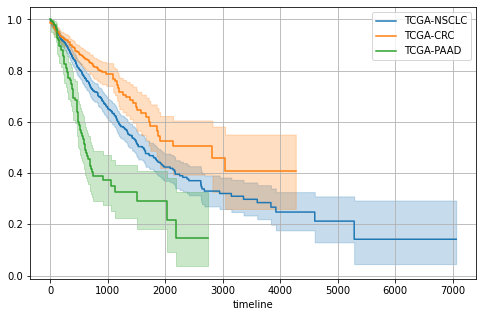

In [34]:
plt.figure(figsize=(8, 5))
for cancer in df['cancer'].unique():
    df_tmp = df.loc[df['cancer'] == cancer]
    km = lifelines.KaplanMeierFitter()
    km.fit(df_tmp['time'], df_tmp['event'])
    km.plot(label=cancer)
plt.grid()
plt.show()

In [35]:
df_test = pd.read_csv('/Data_hackathon/test.csv')
df_test['cancer_sub'] = df_test['cancer']
df_test['cancer'] = df_test['cancer'].map(dic)

In [36]:
df_test

,patient,risk,event,cancer,cancer_sub
0,TCGA-4H-AAAK,0,0,NaN,TCGA-BRCA
1,TCGA-A1-A0SE,0,0,NaN,TCGA-BRCA
2,TCGA-A1-A0SP,0,0,NaN,TCGA-BRCA
3,TCGA-A2-A04R,0,0,NaN,TCGA-BRCA
4,TCGA-A2-A04V,0,1,NaN,TCGA-BRCA
...,...,...,...,...,...
715,TCGA-WE-A8ZM,0,0,NaN,TCGA-SKCM
716,TCGA-WE-A8ZR,0,1,NaN,TCGA-SKCM
717,TCGA-XV-AB01,0,0,NaN,TCGA-SKCM
718,TCGA-YD-A89C,0,0,NaN,TCGA-SKCM


In [37]:
c = dic.keys()
df_test.query('cancer_sub in @c')

,patient,risk,event,cancer,cancer_sub
212,TCGA-5M-AAT6,0,1,TCGA-CRC,TCGA-COAD
213,TCGA-A6-2671,0,1,TCGA-CRC,TCGA-COAD
214,TCGA-A6-2672,0,0,TCGA-CRC,TCGA-COAD
215,TCGA-A6-2674,0,0,TCGA-CRC,TCGA-COAD
216,TCGA-A6-2675,0,0,TCGA-CRC,TCGA-COAD
...,...,...,...,...,...
550,TCGA-IB-7888,0,1,TCGA-PAAD,TCGA-PAAD
551,TCGA-IB-A7LX,0,1,TCGA-PAAD,TCGA-PAAD
552,TCGA-IB-AAUR,0,0,TCGA-PAAD,TCGA-PAAD
553,TCGA-OE-A75W,0,1,TCGA-PAAD,TCGA-PAAD


In [38]:
df_test['cancer_sub'].value_counts()

TCGA-BRCA    212
TCGA-LUSC     94
TCGA-LUAD     93
TCGA-COAD     89
TCGA-SKCM     85
TCGA-PRAD     80
TCGA-PAAD     35
TCGA-READ     32
Name: cancer_sub, dtype: int64

# Histo mean pool

In [87]:
def load_mean_pool_data(df, path_to_features=Path('/hdd1/TCGA_PAAD_moco_full_tiling/')):
    """Load averaged histological features.
    
    Parameters
    ----------
    df: DataFrame
        Dataframe containing survival data
    path_to_features: PosixPath
        Path to the folder containing features (ttv2 format)

    Returns
    -------
    X: numpy array
        feature matrix with size (n_samples, 2048)
    ids: numpy array
        list of patient identifiers
    """
    X = []
    ids = []
    for path in tqdm(list(path_to_features.glob(f'*/features.npy'))):
        filename = str(path).split('/')[-2]
        patient = filename[:12]
        if patient in df['patient'].values:
            x = np.load(path)
            X.append(np.mean(x, axis=0)[3:])  # Remove tile coordinates
            ids.append(patient)
    return np.array(X), np.array(ids)

In [88]:
# Load data for CV
X, ids = load_mean_pool_data(df, path_to_features=Path('/Data_hackathon/MocoCoadReduced/TCGA_LUAD/'))
X_, ids_ = load_mean_pool_data(df, path_to_features=Path('/Data_hackathon/MocoCoadReduced/TCGA_LUSC/'))
X = np.concatenate([X, X_])
ids = np.concatenate([ids, ids_])

X_, ids_ = load_mean_pool_data(df, path_to_features=Path('/Data_hackathon/MocoCoadReduced/TCGA_COAD/'))
X = np.concatenate([X, X_])
ids = np.concatenate([ids, ids_])

X_, ids_ = load_mean_pool_data(df, path_to_features=Path('/Data_hackathon/MocoCoadReduced/TCGA_READ/'))
X = np.concatenate([X, X_])
ids = np.concatenate([ids, ids_])

X_, ids_ = load_mean_pool_data(df, path_to_features=Path('/Data_hackathon/MocoCoadReduced/TCGA_PAAD/'))
X = np.concatenate([X, X_])
ids = np.concatenate([ids, ids_])

  0%|          | 0/528 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/452 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

In [89]:
# Load test data
X_test, ids_test = load_mean_pool_data(df_test, path_to_features=Path('/Data_hackathon/MocoCoadReduced/TCGA_LUAD/'))
X_, ids_ = load_mean_pool_data(df_test, path_to_features=Path('/Data_hackathon/MocoCoadReduced/TCGA_LUSC/'))
X_test = np.concatenate([X_test, X_])
ids_test = np.concatenate([ids_test, ids_])

X_, ids_ = load_mean_pool_data(df_test, path_to_features=Path('/Data_hackathon/MocoCoadReduced/TCGA_COAD/'))
X_test = np.concatenate([X_test, X_])
ids_test = np.concatenate([ids_test, ids_])

X_, ids_ = load_mean_pool_data(df_test, path_to_features=Path('/Data_hackathon/MocoCoadReduced/TCGA_READ/'))
X_test = np.concatenate([X_test, X_])
ids_test = np.concatenate([ids_test, ids_])

X_, ids_ = load_mean_pool_data(df_test, path_to_features=Path('/Data_hackathon/MocoCoadReduced/TCGA_PAAD/'))
X_test = np.concatenate([X_test, X_])
ids_test = np.concatenate([ids_test, ids_])

  0%|          | 0/528 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/452 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

In [90]:
X.shape, ids.shape, X_test.shape, ids_test.shape

((1459, 256), (1459,), (370, 256), (370,))

In [91]:
default_params = {
    'TCGA-NSCLC': {'dim': 256, 'p': 1},
    'TCGA-CRC': {'dim': 256, 'p': 0.1},
    'TCGA-PAAD': {'dim': 256, 'p': 100}
}

In [61]:
# Select one of the cancers here
project_id = 'TCGA-CRC'

In [62]:
X.shape

(1459, 256)

In [63]:
metrics = []
y = df.set_index('patient').loc[ids, ['time', 'event']].values.astype(float)
cancer = df.set_index('patient').loc[ids, 'cancer'].values
cancer_test = df_test.set_index('patient').loc[ids_test, 'cancer'].values

In [67]:
X_ = X[cancer == project_id]
y_ = y[cancer == project_id]
ids_ = ids[cancer == project_id]
cancer_ = cancer[cancer == project_id]

X_test_ = X_test[cancer_test == project_id]
ids_test_ = ids_test[cancer_test == project_id]
pred_test = 0

for k in range(5):

    kf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=k)
    fold = 0

    for train_idx, val_idx in kf.split(ids_, y_[:, 1], groups=ids_):

        X_train = X_[train_idx]
        X_val = X_[val_idx]
        y_train = y_[train_idx]
        y_val = y_[val_idx]
        ids_val = ids_[val_idx]
        
        # Possibility to reduce dimensions with PCA because lifelines.CoxPHFitter may have
        # trouble converging in high dimension
        dim = default_params[project_id]['dim']
        X_test__ = cp.copy(X_test_)
        if dim < 256:
            pca = PCA(dim)
            X_train = pca.fit_transform(X_train)
            X_val = pca.transform(X_val)
            X_test__ = pca.transform(X_test__)

        data_train = pd.DataFrame(X_train)
        data_train['t'] = y_train[:, 0]
        data_train['e'] = y_train[:, 1]

        cph = lifelines.CoxPHFitter(penalizer=default_params[project_id]['p'])
        cph.fit(data_train, 't', event_col='e', show_progress=False, step_size=0.2)

        pred_val = cph.predict_expectation(X_val)
        pred_test += cph.predict_expectation(X_test__).values / 25

        time = y_val[:, 0]
        event = y_val[:, 1]

        df_val = pd.DataFrame(
            {
                'patient': ids_val,
                'time': time,
                'pred': pred_val,
                'event': event,
            }
        )
        c = lifelines.utils.concordance_index(
            event_times=df_val['time'],
            predicted_scores=df_val['pred'],
            event_observed=df_val['event']
        )
        print(f'C-index on fold {fold}: {c:.4f}')
        metrics.append(c)
        fold += 1
    print('-----------------')

C-index on fold 0: 0.4617
C-index on fold 1: 0.6493
C-index on fold 2: 0.5907
C-index on fold 3: 0.7020
C-index on fold 4: 0.6778
-----------------
C-index on fold 0: 0.6244
C-index on fold 1: 0.5750
C-index on fold 2: 0.5980
C-index on fold 3: 0.6127
C-index on fold 4: 0.6107
-----------------
C-index on fold 0: 0.5857
C-index on fold 1: 0.6380
C-index on fold 2: 0.6984
C-index on fold 3: 0.6660
C-index on fold 4: 0.5576
-----------------
C-index on fold 0: 0.6000
C-index on fold 1: 0.6309
C-index on fold 2: 0.6520
C-index on fold 3: 0.6354
C-index on fold 4: 0.5380
-----------------
C-index on fold 0: 0.7484
C-index on fold 1: 0.5567
C-index on fold 2: 0.7079
C-index on fold 3: 0.5488
C-index on fold 4: 0.6266
-----------------


In [15]:
np.mean(metrics)

0.619708026484489

In [16]:
# Save prediction for the selected cancer
pred_test = pd.DataFrame({'patient': ids_test_, 'risk': pred_test })
pred_test.to_csv(f'preds_{project_id}_histo.csv', index=False)

In [17]:
# Once this is done for every cancer, gather predictions in a single file
pd.concat(
    [
        pd.read_csv('preds_TCGA-NSCLC_histo.csv'),
        pd.read_csv('preds_TCGA-CRC_histo.csv'),
        pd.read_csv('preds_TCGA-PAAD_histo.csv'),
    ]
).to_csv('preds_baseline_histo.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'preds_TCGA-NSCLC_histo.csv'

# RNAseq

Here we will use the RNAseq baseline not only to compute risk scores but also to extract genes

In [94]:
df_rna = pd.read_csv(
    '/Data_hackathon/Workflow_outputs/LUAD/LUAD_FPKM-UQ_counts.tsv',
    sep='\t').set_index('gene').T

df_rna = pd.concat([
    df_rna,
    pd.read_csv(
        '/Data_hackathon/Workflow_outputs/LUSC/LUSC_FPKM-UQ_counts.tsv',
        sep='\t'
    ).set_index('gene').T
])

df_rna = pd.concat([
    df_rna,
    pd.read_csv(
        '/Data_hackathon/Workflow_outputs/COAD/COAD_FPKM-UQ_counts.tsv',
        sep='\t'
    ).set_index('gene').T
])

df_rna = pd.concat([
    df_rna,
    pd.read_csv(
        '/Data_hackathon/Workflow_outputs/READ/READ_FPKM-UQ_counts.tsv',
        sep='\t'
    ).set_index('gene').T
])

df_rna = pd.concat([
    df_rna,
    pd.read_csv(
        '/Data_hackathon/Workflow_outputs/PAAD/PAAD_FPKM-UQ_counts.tsv',
        sep='\t'
    ).set_index('gene').T
])

# Exclude genes that have null median expression
columns_to_keep = df_rna.columns[df_rna.median() > 0]
df_rna = df_rna[columns_to_keep]
genes = df_rna.columns

In [95]:
pd.Series(df_rna.index).value_counts()

TCGA-55-6975-01A-11R-1949-07    1
TCGA-2J-AABI-01A-12R-A41B-07    1
TCGA-69-7979-01A-11R-2187-07    1
TCGA-85-A512-01A-11R-A26W-07    1
TCGA-50-5045-01A-01R-1628-07    1
                               ..
TCGA-AD-6890-01A-11R-1928-07    1
TCGA-L4-A4E6-01A-11R-A24H-07    1
TCGA-G5-6572-01A-11R-1830-07    1
TCGA-77-A5G6-01A-11R-A27Q-07    1
TCGA-22-5479-01A-31R-1949-07    1
Length: 1902, dtype: int64

In [96]:
df['patient'].value_counts()

TCGA-CM-6171    1
TCGA-NJ-A4YF    1
TCGA-AF-2690    1
TCGA-95-7567    1
TCGA-AA-A01G    1
               ..
TCGA-78-8640    1
TCGA-F4-6704    1
TCGA-AA-3675    1
TCGA-D5-6923    1
TCGA-18-3410    1
Name: patient, Length: 1374, dtype: int64

In [97]:
# Use the log because gene expressions cover several orders of magnitude
X = np.log(
    1 + df_rna.fillna(0).values
)

# Scale
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

ids = pd.Series(df_rna.index).apply(lambda x: x[:12])

In [98]:
ids.value_counts()

TCGA-44-2668    4
TCGA-44-6146    4
TCGA-A6-5659    4
TCGA-44-6147    4
TCGA-A6-2684    4
               ..
TCGA-93-8067    1
TCGA-85-A53L    1
TCGA-77-6843    1
TCGA-AA-3980    1
TCGA-DY-A1DE    1
Length: 1715, dtype: int64

In [101]:
# define test and CV data
X_test = X[ids.isin(df_test['patient']).values]
X = X[ids.isin(df['patient']).values]

ids_test = ids[ids.isin(df_test['patient']).values].values
ids = ids[ids.isin(df['patient']).values].values

y = df.set_index('patient').loc[ids, ['time', 'event']].values.astype(float)
gene_importances = pd.DataFrame()

In [102]:
default_params = {
    'TCGA-NSCLC': {'dim': 50, 'p': 10},
    'TCGA-CRC': {'dim': 200, 'p': 1},
    'TCGA-PAAD': {'dim': 100, 'p': 0.1}
}

In [103]:
# Select one of the cancers here
project_id = 'TCGA-PAAD'

In [104]:
metrics = []
y = df.set_index('patient').loc[ids, ['time', 'event']].values.astype(float)
cancer = df.set_index('patient').loc[ids, 'cancer'].values
cancer_test = df_test.set_index('patient').loc[ids_test, 'cancer'].values

In [106]:
metrics = []
y = df.set_index('patient').loc[ids, ['time', 'event']].values.astype(float)
cancer = df.set_index('patient').loc[ids, 'cancer'].values
cancer_test = df_test.set_index('patient').loc[ids_test, 'cancer'].values

X_ = X[cancer == project_id]
y_ = y[cancer == project_id]
ids_ = ids[cancer == project_id]
cancer_ = cancer[cancer == project_id]

X_test_ = X_test[cancer_test == project_id]
ids_test_ = ids_test[cancer_test == project_id]
pred_test = 0

gene_importance = []

for k in range(5):

    kf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=k)
    fold = 0

    for train_idx, val_idx in kf.split(ids_, y_[:, 1], groups=ids_):
        break

In [107]:
X_train = X_[train_idx]
X_val = X_[val_idx]
y_train = y_[train_idx]
y_val = y_[val_idx]
ids_val = ids_[val_idx]

cancer
TCGA-CRC      0.210744
TCGA-NSCLC    0.386667
TCGA-PAAD     0.521429
Name: event, dtype: float64

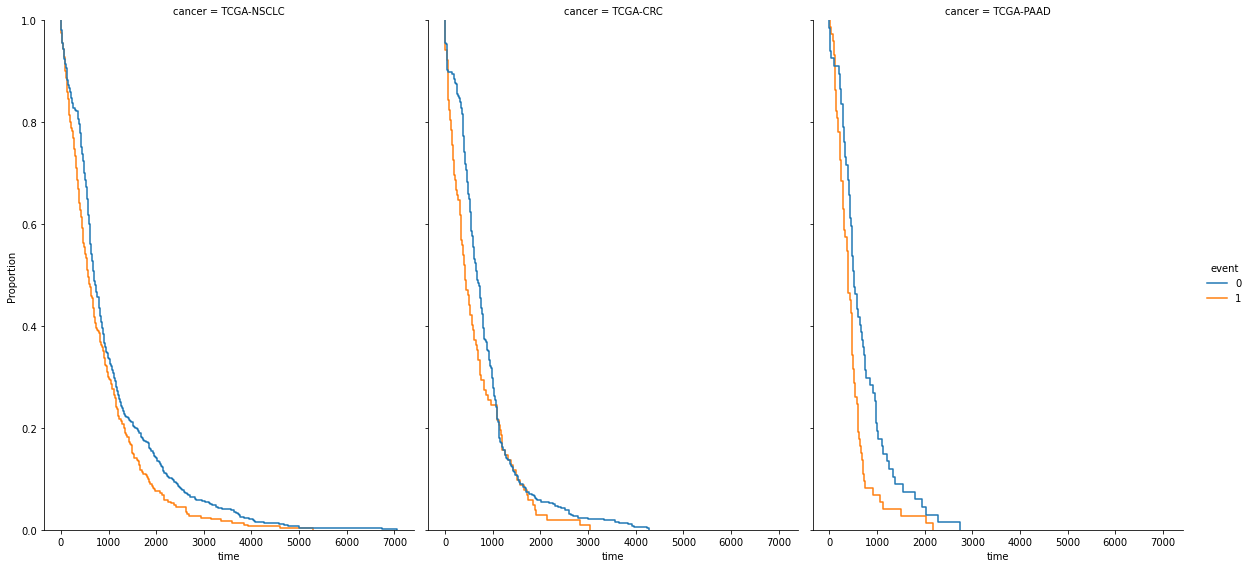

In [118]:
import seaborn as sns

display(df.groupby('cancer')['event'].mean())

sns.displot(
    data=df, x="time", hue="event", col="cancer",
    kind="ecdf", height=8, aspect=.7, complementary=True
);

In [ ]:
# Here it is mandatory to reduce dimension
dim = default_params[project_id]['dim']
pca = PCA(dim)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
X_test__ = pca.transform(X_test_)

# Scale data to ensure Cox beta coefficients are comparable (for gene selection)
X_val = (X_val - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test__ = (X_test__ - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

data_train = pd.DataFrame(X_train)
data_train['t'] = y_train[:, 0]
data_train['e'] = y_train[:, 1]

cph = lifelines.CoxPHFitter(penalizer=default_params[project_id]['p'])
cph.fit(data_train, 't', event_col='e', show_progress=False, step_size=0.2)

# As every operation is linear we can extract contribution values per gene
coefs = np.dot(cph.params_.values, pca.components_)
gene_importance.append(coefs / np.std(coefs))

pred_val = cph.predict_expectation(X_val)
pred_test += cph.predict_expectation(X_test__).values / 25

time = y_val[:, 0]
event = y_val[:, 1]

df_val = pd.DataFrame(
    {
        'patient': ids_val,
        'time': time,
        'pred': pred_val,
        'event': event,
    }
)
c = lifelines.utils.concordance_index(
    event_times=df_val['time'],
    predicted_scores=df_val['pred'],
    event_observed=df_val['event']
)
print(f'C-index on fold {fold}: {c:.4f}')
metrics.append(c)
fold += 1
print('-----------------')

In [105]:
# old
        X_train = X_[train_idx]
        X_val = X_[val_idx]
        y_train = y_[train_idx]
        y_val = y_[val_idx]
        ids_val = ids_[val_idx]
        
        # Here it is mandatory to reduce dimension
        dim = default_params[project_id]['dim']
        pca = PCA(dim)
        X_train = pca.fit_transform(X_train)
        X_val = pca.transform(X_val)
        X_test__ = pca.transform(X_test_)

        # Scale data to ensure Cox beta coefficients are comparable (for gene selection)
        X_val = (X_val - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
        X_test__ = (X_test__ - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
        X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

        data_train = pd.DataFrame(X_train)
        data_train['t'] = y_train[:, 0]
        data_train['e'] = y_train[:, 1]

        cph = lifelines.CoxPHFitter(penalizer=default_params[project_id]['p'])
        cph.fit(data_train, 't', event_col='e', show_progress=False, step_size=0.2)

        # As every operation is linear we can extract contribution values per gene
        coefs = np.dot(cph.params_.values, pca.components_)
        gene_importance.append(coefs / np.std(coefs))

        pred_val = cph.predict_expectation(X_val)
        pred_test += cph.predict_expectation(X_test__).values / 25

        time = y_val[:, 0]
        event = y_val[:, 1]

        df_val = pd.DataFrame(
            {
                'patient': ids_val,
                'time': time,
                'pred': pred_val,
                'event': event,
            }
        )
        c = lifelines.utils.concordance_index(
            event_times=df_val['time'],
            predicted_scores=df_val['pred'],
            event_observed=df_val['event']
        )
        print(f'C-index on fold {fold}: {c:.4f}')
        metrics.append(c)
        fold += 1
    print('-----------------')

C-index on fold 0: 0.4021
C-index on fold 1: 0.5892
C-index on fold 2: 0.7000
C-index on fold 3: 0.5677
C-index on fold 4: 0.5038
-----------------
C-index on fold 0: 0.4864
C-index on fold 1: 0.6528
C-index on fold 2: 0.5543
C-index on fold 3: 0.4875
C-index on fold 4: 0.6302
-----------------
C-index on fold 0: 0.7234
C-index on fold 1: 0.6192
C-index on fold 2: 0.7299
C-index on fold 3: 0.5720
C-index on fold 4: 0.4769
-----------------
C-index on fold 0: 0.5899
C-index on fold 1: 0.5789
C-index on fold 2: 0.4729
C-index on fold 3: 0.4502
C-index on fold 4: 0.4925
-----------------
C-index on fold 0: 0.4958
C-index on fold 1: 0.5286
C-index on fold 2: 0.6767
C-index on fold 3: 0.5233
C-index on fold 4: 0.5076
-----------------


In [79]:
np.mean(metrics)

0.5604680814595968

In [223]:
# Save predictions for the selected cancer

pred_test = pd.DataFrame({patient: ids_test_, 'risk': pred_test})
pred_test.to_csv(f'preds_{project_id}_rnaseq.csv', index=False)

In [82]:
# Save weights of genes

average_weight = np.mean(gene_importance, axis=0)
average_weight = pd.Series(average_weight, index=genes)
gene_importances[f'{project_id}'] = average_weight

In [233]:
# Once this is done for every cancer, gather predictions in a single file

pd.concat(
    [
        pd.read_csv('preds_TCGA-NSCLC_rnaseq.csv'),
        pd.read_csv('preds_TCGA-CRC_rnaseq.csv'),
        pd.read_csv('preds_TCGA-PAAD_rnaseq.csv'),
    ]
).to_csv('preds_baseline_rnaseq.csv', index=False)

In [225]:
# Aggregate gene contributions over every cancer

top_genes =gene_importances.mean(axis=1).sort_values().tail(50).index.values
pkl.dump(top_genes, open('top_50_genes.pkl', 'wb'))